[Note] 
- Training a tokenizer is not the same as training a model! 
- Model training uses stochastic gradient descent to make the loss a little bit smaller for each batch. It’s randomized by nature (meaning you have to set some seeds to get the same results when doing the same training twice). 
- Training a tokenizer is a statistical process that tries to identify which subwords are the best to pick for a given corpus, and the exact rules used to pick them depend on the tokenization algorithm. It’s deterministic, meaning you always get the same results when training with the same algorithm on the same corpus.

### Tokenization Steps:

- Normalization (any cleanup of the text that is deemed necessary, such as removing spaces or accents, Unicode normalization, etc.)
- Pre-tokenization (splitting the input into words)
- Running the input through the model (using the pre-tokenized words to produce a sequence of tokens)
- Post-processing (adding the special tokens of the tokenizer, generating the attention mask and token type IDs)

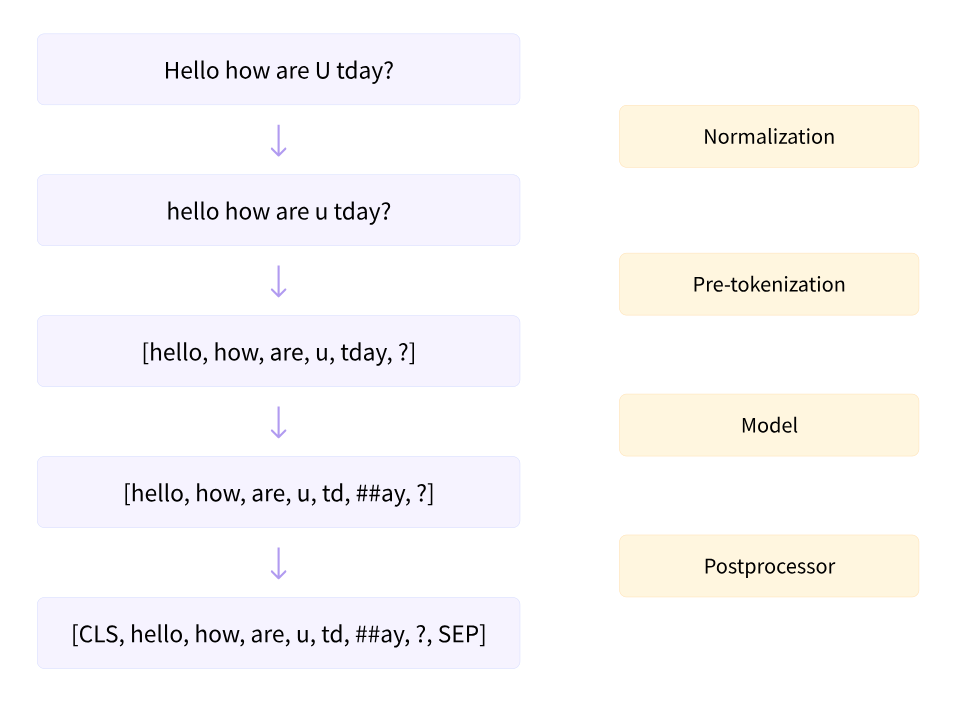

In [1]:
from datasets import load_dataset
dataset = load_dataset("wikitext", name="wikitext-2-raw-v1", split="train")


Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [2]:
#Generator that will yield batches of 1,000 texts, which we will use to train the tokenizer
def get_training_corpus():
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["text"]

### Building a WordPiece tokenizer from scratch

In [3]:
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

In [4]:
##unk_token so the model knows what to return when it encounters characters it hasn’t seen before
tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]")) 

In [5]:
# Normalization 
## tokenizer.normalizer = normalizers.BertNormalizer(lowercase=True)
tokenizer.normalizer = normalizers.Sequence(
    [normalizers.NFD(), normalizers.Lowercase(), normalizers.StripAccents()]
)

In [6]:
print(tokenizer.normalizer.normalize_str("Héllò hôw are ü?"))

hello how are u?


In [7]:
## Pre-tokenizer
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

Whitespace pre-tokenizer splits on whitespace and all characters that are not letters, digits, or the underscore character, so it technically splits on whitespace and punctuation:

In [8]:
tokenizer.pre_tokenizer.pre_tokenize_str("Let's test my pre-tokenizer.")

[('Let', (0, 3)),
 ("'", (3, 4)),
 ('s', (4, 5)),
 ('test', (6, 10)),
 ('my', (11, 13)),
 ('pre', (14, 17)),
 ('-', (17, 18)),
 ('tokenizer', (18, 27)),
 ('.', (27, 28))]

- vocab_size  
- special_tokens
- min_frequency (the number of times a token must appear to be included in the vocabulary) or change the continuing_subword_prefix (if we want to use something different from ##).

In [9]:
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
# Special tokens you intend to use — otherwise it won’t add them to the vocabulary
trainer = trainers.WordPieceTrainer(vocab_size=25000, special_tokens=special_tokens)

In [10]:
tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)

In [11]:
encoding = tokenizer.encode("Let's test this tokenizer.")
print(encoding.tokens)

['let', "'", 's', 'test', 'this', 'tok', '##eni', '##zer', '.']


In [12]:
encoding = tokenizer.encode("Let's test this tokenizer...", "on a pair of sentences.")
print(encoding.tokens)
print(encoding.type_ids)

['let', "'", 's', 'test', 'this', 'tok', '##eni', '##zer', '...', 'on', 'a', 'pair', 'of', 'sentences', '.']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]


In [13]:
tokenizer.save("tokenizer.json")